# UAV_Body Classification

In [1]:
data_dir=r"D:\Data centr\IMG_data\UAV_Data"

In [2]:
img_hgt=224
img_wdt=224
batch_sze=32

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8,1.2],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

In [5]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_hgt, img_wdt),
    batch_size=batch_sze,
    class_mode="categorical",
    subset="training"
)

Found 73 images belonging to 10 classes.


In [6]:
val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_hgt, img_wdt),
    batch_size=batch_sze,
    class_mode="categorical",
    subset="validation"
)

Found 14 images belonging to 10 classes.


In [7]:
n_classes = len(train_data.class_indices)

# Model Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D,MaxPooling2D,Flatten,Dense,Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [9]:
model_Vanilla=Sequential([
    Input(shape=(img_hgt, img_wdt, 3)),
    Conv2D(16, (3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(n_classes, activation="softmax")
])

In [10]:
model_Vanilla.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
print("Current Learning Rate:", model_Vanilla.optimizer.learning_rate.numpy())
model_Vanilla.summary()

Current Learning Rate: 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,196,138 (4.56 MB)

 Trainable params: 1,196,138 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,               # if val_loss doesn’t improve for 5 epochs → stop
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_part_classifier.h5",
    monitor="val_loss",
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,           # cut LR in half
    patience=3,           # after 3 non‑improving epochs
    min_lr=1e-6
)

In [14]:
history = model_Vanilla.fit(
    train_data,
    validation_data=val_data,
    epochs=30,                # bump up max epochs
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1198 - loss: 2.2967   

3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 14s/step - accuracy: 0.1310 - loss: 2.2861 - val_accuracy: 0.2143 - val_loss: 2.2069
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1569 - loss: 2.2531

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - accuracy: 0.1588 - loss: 2.2493 - val_accuracy: 0.2143 - val_loss: 2.1525
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1879 - loss: 2.1760

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.1923 - loss: 2.1713 - val_accuracy: 0.2143 - val_loss: 2.0428
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.2898 - loss: 2.0516 

3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 22s/step - accuracy: 0.2687 - loss: 2.0830 - val_accuracy: 0.2143 - val_loss: 1.9573
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 18s/step - accuracy: 0.2734 - loss: 2.1200 - val_accuracy: 0.2857 - val_loss: 1.9702
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 26s/step - accuracy: 0.3220 - loss: 2.0358 - val_accuracy: 0.2143 - val_loss: 2.0202
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2721 - loss: 1.9169 

3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 23s/step - accuracy: 0.2794 - loss: 1.9219 - val_accuracy: 0.2857 - val_loss: 1.8219
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.3286 - loss: 1.8536 - val_accuracy: 0.4286 - val_loss: 1.9079
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.4086 - loss: 1.7803 - val_accuracy: 0.3571 - val_loss: 1.8725
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4409 - loss: 1.7853 

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.4300 - loss: 1.7723 - val_accuracy: 0.4286 - val_loss: 1.7127
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.4039 - loss: 1.7977 - val_accuracy: 0.2857 - val_loss: 2.2611
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.4212 - loss: 1.6047 - val_accuracy: 0.2857 - val_loss: 2.0156
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.4657 - loss: 1.7334 - val_accuracy: 0.4286 - val_loss: 1.8424
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4878 - loss: 1.7314

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 12s/step - accuracy: 0.4926 - loss: 1.6886 - val_accuracy: 0.4286 - val_loss: 1.6962
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step - accuracy: 0.5272 - loss: 1.5866 - val_accuracy: 0.5000 - val_loss: 1.7624
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step - accuracy: 0.5265 - loss: 1.3211 - val_accuracy: 0.4286 - val_loss: 1.9921
Epoch 17/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.4366 - loss: 1.5537 - val_accuracy: 0.4286 - val_loss: 2.0507
Epoch 18/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.4956 - loss: 1.3671 - val_accuracy: 0.2857 - val_loss: 1.8657
Epoch 19/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 10s/step - accuracy: 0.3852 - loss: 1.6209 - val_accuracy: 0.5000 - val_loss: 1.8454


In [18]:
val_loss, val_acc = model_Vanilla.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3571 - loss: 1.8408
Validation Loss: 1.8408
Validation Accuracy: 35.71%


In [15]:
class_name=list(train_data.class_indices.keys()) # A dictionary mapping class names to integer labels list.
print("Class Label:",class_name)

Class Label: ['BodyFuselage', 'Component', 'LandingGear', 'LeftWing', 'NoseFuselasge', 'PayloadBox', 'RightWing', 'Tail', 'VTOL', 'Verti@X3']


In [19]:
import matplotlib.pyplot as plt

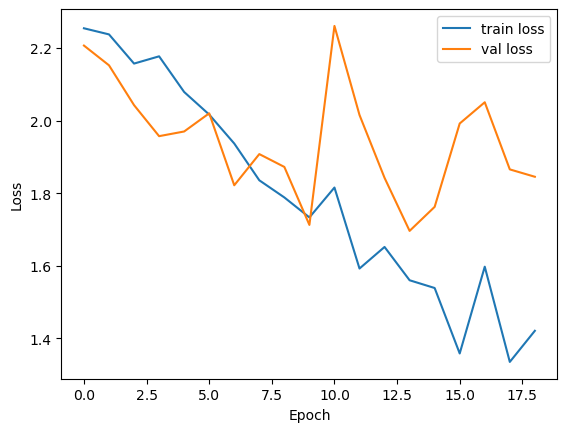

In [20]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Model Prediction

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [31]:
def predict_body(image_path):
    # 1. Load & resize
    img = image.load_img(image_path, target_size=(img_hgt, img_wdt))
    
    # 2. To array & batch dimension
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # 3. Preprocess (scale & mean‑center if using a pretrained backbone)
    x = preprocess_input(x)
    
    # 4. Model prediction
    preds = model_Vanilla.predict(x)
    idx   = np.argmax(preds[0])
    label = class_name[idx]
    confidence = float(preds[0][idx])
    
    # 5. Display
    plt.figure(figsize=(6,6))
    plt.imshow(image.load_img(image_path))  # show original
    plt.axis("off")
    plt.title(f"Predicted: {label}\nConfidence: {confidence*100:.2f}%")
    plt.show()
    
    return label, confidence


In [32]:
from tensorflow.keras.layers import Rescaling

In [33]:
model_preprocessed=tf.keras.Sequential([
    Rescaling(1./255, input_shape=(224,224,3)), # Normalize layer
    model_Vanilla
])

d:\Program_file\Anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
img_pth=r"D:\Data centr\IMG_data\UAV_Data\PayloadBox\IMG_20250401_161122997.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


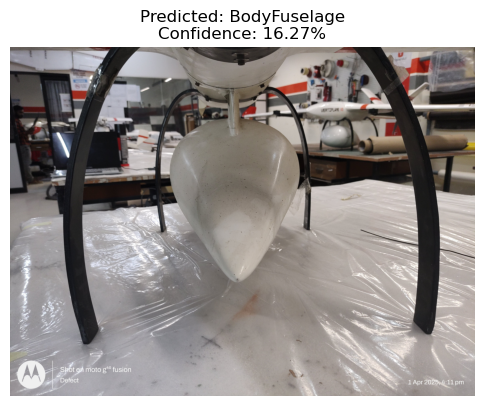

Predicted: BodyFuselage, Confidence: 16.27%


In [41]:
flower_type, confidence = predict_body(img_pth)
print(f"Predicted: {flower_type}, Confidence: {confidence*100:.2f}%")